In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv('Fraud.csv')

In [5]:
print(df.head())
print(df['isFraud'].value_counts())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
isFraud
0    6354407
1       8213
Name: count, dtype: int64


In [6]:
df.drop_duplicates(inplace=True)

In [7]:
le_type = LabelEncoder()
le_orig = LabelEncoder()
le_dest = LabelEncoder()
df['type'] = le_type.fit_transform(df['type'])
df['nameOrig'] = le_orig.fit_transform(df['nameOrig'])
df['nameDest'] = le_dest.fit_transform(df['nameDest'])

In [8]:
df['diffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['diffDest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['trans_ratio'] = df['amount'] / (df['oldbalanceOrg'] + 1)

In [9]:
df.drop(['step', 'isFlaggedFraud'], axis=1, inplace=True)

In [10]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [13]:
scale_weight = (len(y_train) - sum(y_train)) / sum(y_train)

In [14]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_weight, random_state=42)
model.fit(X_train_scaled, y_train)

C:\Users\mahap\AppData\Roaming\Python\Python311\site-packages\xgboost\training.py:183: UserWarning: [19:43:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [15]:
y_pred = model.predict(X_val_scaled)
y_proba = model.predict_proba(X_val_scaled)[:, 1]

In [16]:
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

Confusion Matrix:
[[1269830    1051]
 [     26    1617]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.61      0.98      0.75      1643

    accuracy                           1.00   1272524
   macro avg       0.80      0.99      0.87   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC Score: 0.9996


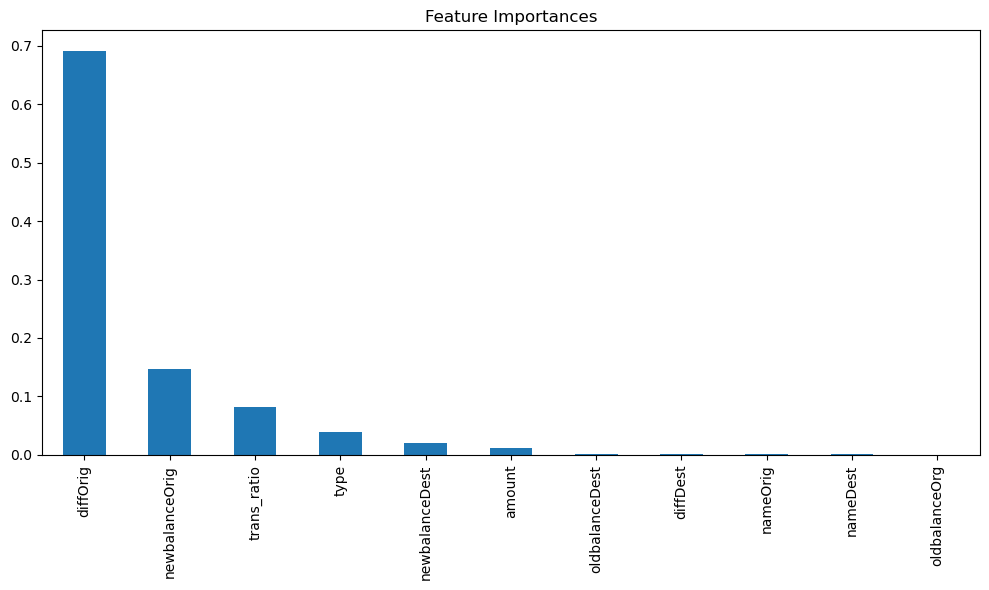

In [17]:
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar')
plt.title("Feature Importances")
plt.tight_layout()
plt.show()